# Анализ данных полупроводникового газового сенсора

Импорт необходимых библиотек:

In [2]:
import numpy as np
import scipy.integrate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.optimize import curve_fit
import math

The PA signal measured by the microphone, is given by:

$$ S = C P(\lambda) \alpha(\lambda) = C P(\lambda) \sigma(\lambda) N $$

where $C$ is the cell constant in the unit of Vcm/W, $P$ the optical power of the laser source and $\alpha$ the absorption coefficient which is related to the gas concentration ($N$, number density of molecules) and absorption cross section (\sigma) by $\alpha = N \sigma$. The cell constant depends on the geometry of the sample cell, the beam profile, the microphone response and the nature of the acoustic mode.

## Формула для измерения концентрации по изместным данным:

Concentration is equal to 972.672220886215 ppm
func: Amp, alpha:
0.14884810058159373 0.0002455031482167493


/var/folders/4l/x39d6t210x513txrbx38qvmm0000gn/T/ipykernel_6095/43879577.py:12: RuntimeWarning: overflow encountered in exp
  return Amp*(1.0-np.exp(-alpha*x))


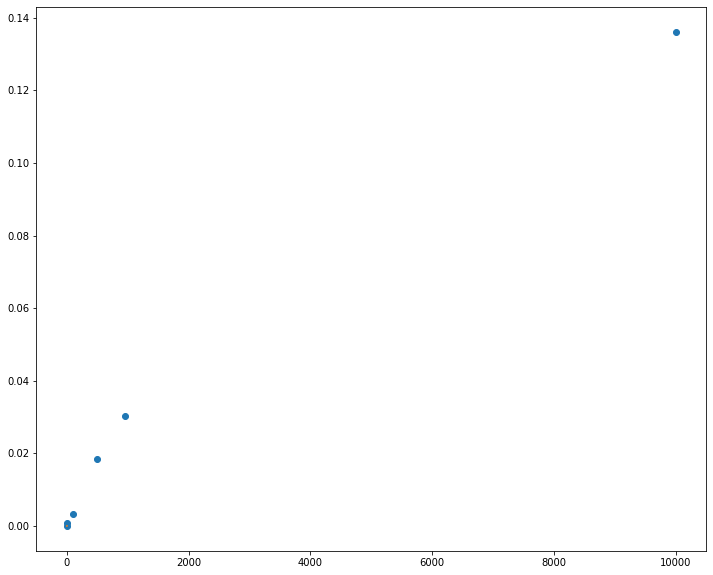

In [3]:
N = np.array([2.5, 9.7, 97, 500, 954, 10000])
OAD_Pyro = np.array([1.57646E-4, 7.22773E-4, 0.00331, 0.01845, 0.03035, 0.13608])
z = np.polyfit(OAD_Pyro[:5], N[:5], 1)
N_poly = np.poly1d(z)
print("Concentration is equal to", N_poly(0.032), "ppm")
# plt.plot(OAD_Pyro, N, 'o')

# N = N/10000


def func_theory(x, Amp, alpha):
    return Amp*(1.0-np.exp(-alpha*x))

popt, pcov = curve_fit(func_theory, N, OAD_Pyro)

Amp,alpha = popt

print('func: Amp, alpha:')
print(Amp,alpha)



point = np.arange(0, 2, 0.0001)
ans = func_theory(point, Amp, alpha)
# print('Fit')
# print(ans)


plt.subplots(sharey = True, figsize = (12, 10))
plt.plot(N, OAD_Pyro,'o')
plt.plot(point, ans)


# plt.subplots(sharey = True, figsize = (12, 10))
# div = OAD_Pyro - func_theory(N, Amp, alpha)
# plt.plot(N, div)


# plt.subplots(sharey = True, figsize = (12, 10))
# div_persent = div/OAD_Pyro*100
# plt.plot(div_persent)

## Чтение "сырых" данных из файла:

- x     - время (1 секунда, 48000 точек)

- Pyro - сигнал с пироприёмника (мощность накачки)

- OAD  - сигнал с микрофона (оптико-акустического фотодетектора)

- y2   - пустой столбец, не рассматриваем

- Ref  - сигнал с реперной ячейки, содержащей определённую концентрацию газа

Сигнал с микрофона (OAD) нормируется на сигнал c Pyro (нормировка по мощности лазера).
$S_{norm} = (C P(t) N_1) / (C P(t) N_{ref}) = N_1 / N_{ref}, N_1 = N_{ref} S_{norm} $

Частота оцифровки на АЦП - 48 кГц ($\sim$ 2 10$^{-5}$ c)

Далее определим концентрацию метана:

           x         Pyro         OAD      y2         Ref      Norm
0          0  637755000.0 -33743600.0 -159744   -547072.0 -0.052910
1          1  665619000.0 -31618000.0 -164608  -8699900.0 -0.047502
2          2  712540000.0 -28067100.0 -190976 -10134300.0 -0.039390
3          3  731017000.0 -22965000.0 -189440 -12043300.0 -0.031415
4          4  797159000.0 -16724700.0 -189952 -14116600.0 -0.020980
...      ...          ...         ...     ...         ...       ...
47995  47995 -475278000.0   7954690.0 -171776  16955100.0 -0.016737
47996  47996 -312825000.0    126464.0 -185856  18132700.0 -0.000404
47997  47997  -22991600.0  -7788030.0 -161792  16607700.0  0.338734
47998  47998   68592900.0 -15332400.0 -177408  11885100.0 -0.223528
47999  47999  270396000.0 -22122200.0 -180224   8439300.0 -0.081814

[48000 rows x 6 columns]
163.72647849462365
-199.70500341530055
x        23999.500000
Pyro    326844.158542
OAD    -384755.391083
y2     -180566.522667
Ref     200584.261250
Norm     

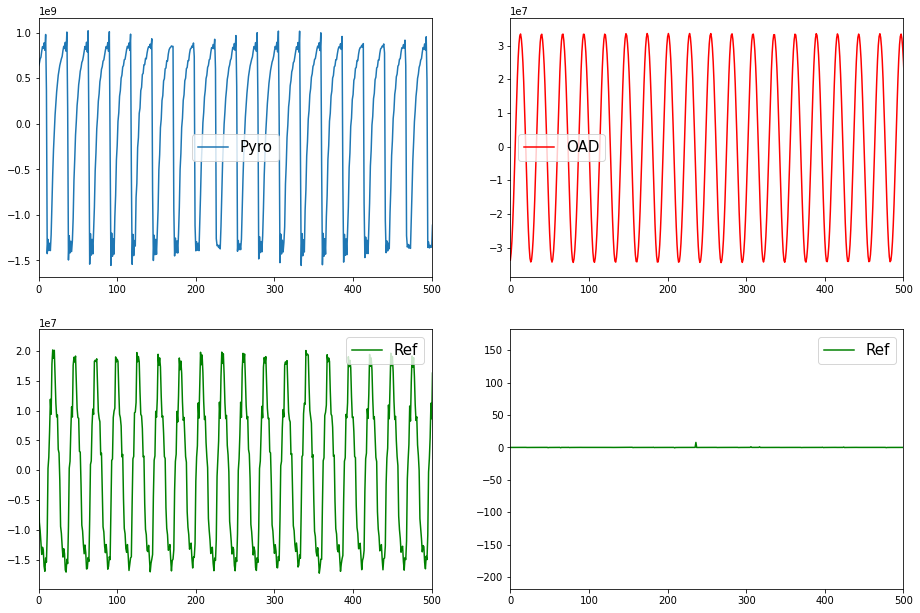

In [29]:
file_name = 'raw CH4 954 ppm'
df1 = pd.read_csv(file_name, delim_whitespace=True, quotechar="\"") 

df1['Norm'] = df1.OAD/df1.Pyro
print(df1)



fig = plt.figure()
fig.set_size_inches(15.5, 10.5)
ax1 = fig.add_subplot(221)
ax1.set_xlim([0, 500])
ax1.plot(df1.x,df1.Pyro, label='Pyro')
ax1.legend(prop={'size': 15})

ax2 = fig.add_subplot(222)
ax2.set_xlim([0, 500])
ax2.plot(df1.x,df1.OAD, 'red',  label='OAD')
ax2.legend(prop={'size': 15})

ax3 = fig.add_subplot(223)
ax3.set_xlim([0, 500])
ax3.plot(df1.x,df1.Ref, 'green',   label='Ref')
ax3.legend(prop={'size': 15})


ax4 = fig.add_subplot(224)
ax4.set_xlim([0, 500])
print(df1.Norm.max())
print(df1.Norm.min())
print(df1.mean())
ax4.plot(df1.x,df1.Norm, 'green',   label='Ref')
ax4.legend(prop={'size': 15})




## Преобразование Фурье на АЦП:

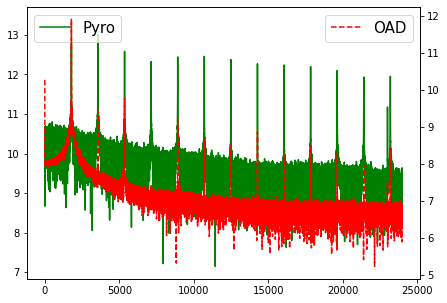

In [20]:
SAMPLE_RATE = 48000 #Hz
DURATION = 1 #sec
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

Pyro = df1.Pyro.values
Pyro_f = rfft(Pyro)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

OAD = df1.OAD.values
OAD_f = rfft(OAD)

Ref = df1.Ref.values

fig = plt.figure()
fig.set_size_inches(15.5, 5.0)
ax1 = fig.add_subplot(121)
ax2 = ax1.twinx()
ax1.plot(xf, np.log10(np.abs(Pyro_f)), 'green', label='Pyro')
ax2.plot(xf, np.log10(np.abs(OAD_f)), color='red', linestyle='--', label='OAD')
ax1.legend(prop={'size': 15},loc='upper left')
ax2.legend(prop={'size': 15},loc='upper right')

## Построение временного ряда:


In [21]:
SAMPLE_RATE = 48000 #Hz
DURATION = 1 #sec
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

max_intensity_OAD = np.zeros(200)
max_index_OAD = np.zeros(200)
max_intensity_Pyro = np.zeros(200)
max_index_Pyro = np.zeros(200)

for i in range(100):
    ind = i if i>=10 else f"0{i}"
    file_name = f"CH4 954 ppm raw/{ind}" # в каждом файле записано 2 секунды
    df = pd.read_csv(file_name, delim_whitespace=True, quotechar="\"") 

    Pyro = df.y0.values[0:SAMPLE_RATE-1]
    OAD = df.y1.values[0:SAMPLE_RATE-1]

    xf = rfftfreq(N, 1 / SAMPLE_RATE)
    Pyro_f = rfft(Pyro)
    OAD_f = rfft(OAD)

    max_intensity_OAD[2*i] = np.max(np.abs(OAD_f))
    max_index_OAD[2*i] = np.argmax(np.abs(OAD_f))
    max_intensity_Pyro[2*i] = np.max(np.abs(Pyro_f))
    max_index_Pyro[2*i] = np.argmax(np.abs(Pyro_f))

    Pyro = df.y0.values[SAMPLE_RATE:]
    OAD = df.y1.values[SAMPLE_RATE:]
    Pyro_f = rfft(Pyro)
    OAD_f = rfft(OAD)
    max_intensity_OAD[2*i+1] = np.max(np.abs(OAD_f))
    max_index_OAD[2*i+1] = np.argmax(np.abs(OAD_f))
    max_intensity_Pyro[2*i+1] = np.max(np.abs(Pyro_f))
    max_index_Pyro[2*i+1] = np.argmax(np.abs(Pyro_f))

Преобразованные на АЦП данные:

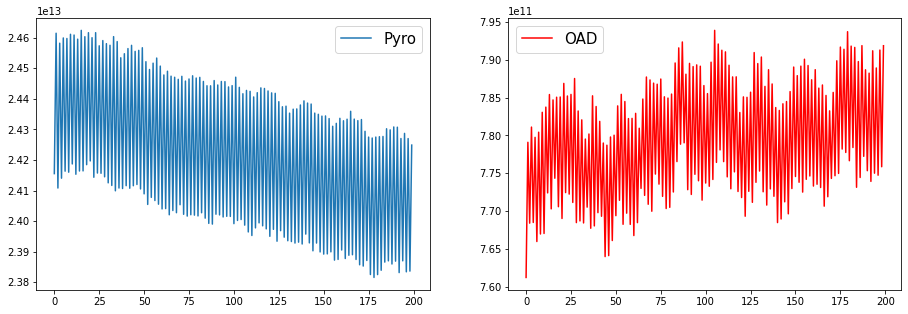

In [22]:
fig = plt.figure()
fig.set_size_inches(15.5, 5)
ax1 = fig.add_subplot(121)
ax1.plot([i for i in range(200)],max_intensity_Pyro, label='Pyro')
ax1.legend(prop={'size': 15})

ax2 = fig.add_subplot(122)
ax2.plot([i for i in range(200)],max_intensity_OAD, 'red', label='OAD')
ax2.legend(prop={'size': 15})

## Вычисление концентрации:

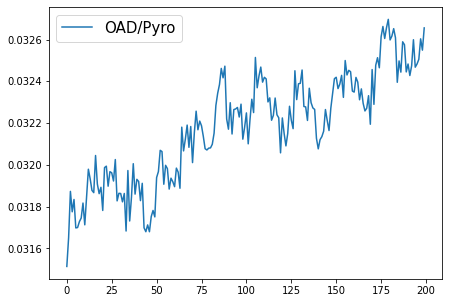

In [23]:
S = max_intensity_OAD/max_intensity_Pyro
fig = plt.figure()
fig.set_size_inches(15.5, 5)
ax1 = fig.add_subplot(121)
ax1.plot([i for i in range(200)],S, label='OAD/Pyro')
ax1.legend(prop={'size': 15})

## Butterworth filtration

b= [0.13672874 0.13672874]
a= [ 1.         -0.72654253]


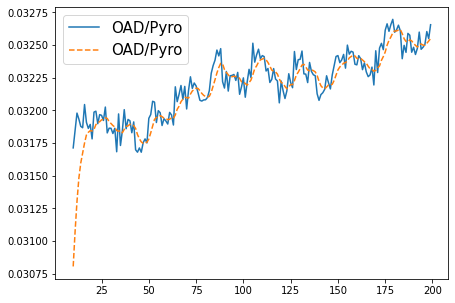

In [24]:
def ButterFiltration(s,dt,T):
    """
    High-pass filter (Butterworth filter)
    """
    s_filtered = np.zeros(len(s))
    y0 = s[0]
    butterorder = 1
    butterfreq = 0.05 # in Hz for "high"
    b, a = signal.butter(butterorder, butterfreq * dt * 2, 'low')
    print("b=",b)
    print("a=",a)
    ys = np.zeros((butterorder+1,1)) + y0
    HPF = np.zeros((butterorder+1,1))

    yvals = np.zeros((int(T/dt),1))
    for i in range(0,int(T/dt)):
        t = i*dt
        yvals[i] = s[i]

        for k in range(0,butterorder):
            ys[k] = ys[k+1]
            HPF[k]= HPF[k+1]
        ys[butterorder] = yvals[i]
        HPFnew = 0;

        for k in range(0,butterorder+1):
            HPFnew = HPFnew + b[k]*ys[butterorder-k]

        for k in range(1,butterorder+1):
            HPFnew = HPFnew - a[k]*HPF[butterorder-k]

        HPF[butterorder] = HPFnew  
        s_filtered[i] = HPFnew
    return(s_filtered)

S_filtered = ButterFiltration(S,1,200)
fig = plt.figure()
fig.set_size_inches(15.5, 5)
ax1 = fig.add_subplot(121)
ax1.plot([i for i in range(10,200)],S[10:], label='OAD/Pyro')
ax1.plot([i for i in range(10,200)],S_filtered[10:], '--',label='OAD/Pyro')
ax1.legend(prop={'size': 15})


## ВЕЙВЛЕТ ПРЕОБРАЗОВАНИЕ СИГНАЛА

In [54]:
g_0 = 1.4
g_1 = 1.03
m_0 = 28.97
m_1 = 146.06

freq = 1755

n = 1_000_000 * 1e-6

gamma_factor = (n / (g_1 - 1) + (g_0 - n)/(g_0 - 1) ) / ( g_0 * (1 - n) / (g_0 - 1) + g_0 * n / (g_1 - 1) )

mass_factor = 1 / (1 - n + (m_1/m_0)*n)


print(np.sqrt(gamma_factor*mass_factor) - 1)

print(freq*(np.sqrt(gamma_factor*mass_factor) - 1))
print(freq*(np.sqrt(gamma_factor*mass_factor)))
# print(np.sqrt(g_1*m_0/(g_0*m_1)))

-0.6180001486054677
-1084.5902608025958
670.4097391974042


[223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322]


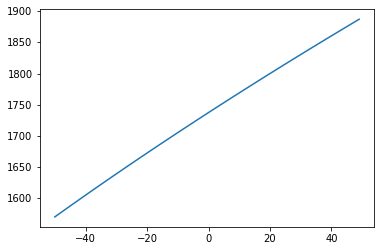

3.0690559370750936


In [69]:
T = np.arange(273 - 50,273 + 50,1)
print(T)
plt.figure()
plt.plot(T - 273, 1800*(np.sqrt(T/293)))

plt.show()

print(1800*(np.sqrt(294/293)-1))